In [1]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy.stats import iqr
import math
import progressbar
import time

### Import Data

In [2]:
# Grab all data from parquet file
dataset = pd.read_parquet('Metal_all_20180116.snappy.parquet')

# Grab only the zinc binding sequences
zinc_dataset = dataset.loc[dataset['ligandId'] == 'ZN']

### Remove Sequence with Unwanted Representations (X/U/B) and Get Zinc Data Only

In [3]:
# Boolean Column to indicate which row contains 'X' and 'U'.
xub_flag = list()
# This will be used later to get rid of outliers
seq_len = list()   

# Fill in 'xub_flag' and 'seq_len'
for row in zinc_dataset.itertuples() :
    if ('X' in row[5]) or ('U' in row[5]) or ('B' in row[5]) : xub_flag.append(1)
    else : xub_flag.append(0)
    seq_len.append( len(row[5]) )
    
# Append the columns
xub_col = pd.DataFrame({'xub_col' : xub_flag})
length_col = pd.DataFrame({'seq_length' : seq_len})
# Reset Index
xub_col = xub_col.reset_index(drop=True)
length_col = length_col.reset_index(drop=True)
zinc_dataset = zinc_dataset.reset_index(drop=True)
# Combine the columns
zinc_dataset = zinc_dataset.join(xub_col)
zinc_dataset = zinc_dataset.join(length_col)

# Exclude sequences containing 'X' and 'U' and 'B'
zinc_dataset = zinc_dataset[zinc_dataset.xub_col != 1]
zinc_dataset = zinc_dataset.drop('xub_col', axis=1)
zinc_dataset

,structureChainId,ligandId,fingerprint,groupNumber,sequence,interactingChains,clusterNumber30,clusterNumber40,clusterNumber50,clusterNumber70,clusterNumber90,clusterNumber95,clusterNumber100,seq_length
0,1AJD.B,ZN,"[50, 101, 368, 369]","[51, 102, 369, 370]",TPEMPVLENRAAQGDITAPGGARRLTGDQTAALRDSLSDKPAKNII...,1,584.0,592.0,555.0,515.0,485.0,444.0,8044.0,449
1,1AJD.B,ZN,"[326, 330, 411]","[327, 331, 412]",TPEMPVLENRAAQGDITAPGGARRLTGDQTAALRDSLSDKPAKNII...,1,584.0,592.0,555.0,515.0,485.0,444.0,8044.0,449
2,1ALN.A,ZN,"[101, 128, 131]","[102, 129, 132]",MHPRFQTAFAQLADNLQSALEPILADKYFPALLTGEQVSSLKSATG...,1,4526.0,4989.0,13948.0,15950.0,17149.0,17499.0,19782.0,294
3,1CG2.A,ZN,"[89, 118, 177]","[112, 141, 200]",ALAQKRDNVLFQAATDEQPAVIKTLEKLVNIETGTGDAEGIAAAGN...,1,10402.0,12008.0,13323.0,15154.0,16224.0,16540.0,18316.0,393
4,1CG2.A,ZN,"[118, 153, 362]","[141, 176, 385]",ALAQKRDNVLFQAATDEQPAVIKTLEKLVNIETGTGDAEGIAAAGN...,1,10402.0,12008.0,13323.0,15154.0,16224.0,16540.0,18316.0,393
5,1CK1.A,ZN,"[82, 117, 121]","[83, 118, 122]",ESQPDPMPDDLHKSSEFTGTMGNMKYLYDDHYVSATKVKSVDKFLA...,1,329.0,486.0,498.0,1420.0,1401.0,1376.0,27622.0,239
6,1E31.B,ZN,"[56, 59, 76, 83]","[57, 60, 77, 84]",MGAPTLPPAWQPFLKDHRISTFKNWPFLEGCACTPERMAEAGFIHC...,1,1654.0,1691.0,1674.0,1634.0,1678.0,1642.0,2605.0,142
7,1IAG.A,ZN,"[141, 145, 151]","[142, 146, 152]",ENLPQRYIELVVVADRRVFMKYNSDLNIIRTRVHEIVNIINKFYRS...,1,1240.0,1730.0,2154.0,6944.0,18434.0,18919.0,62207.0,202
8,1LR5.C,ZN,"[56, 58, 62, 105]","[57, 59, 63, 106]",SCVRDNSLVRDISQMPQSSYGIEGLSHITVAGALNHGMKEVEVWLQ...,1,6660.0,7552.0,8231.0,9103.0,9534.0,9649.0,9489.0,163
9,1TO5.C,ZN,"[64, 72, 81, 84]","[62, 70, 79, 82]",GSNMKAVCVMTGTAGVKGVVKFTQETDNGPVHVHAEFSGLKAGKHG...,1,66.0,70.0,55.0,7056.0,9563.0,9678.0,9527.0,156


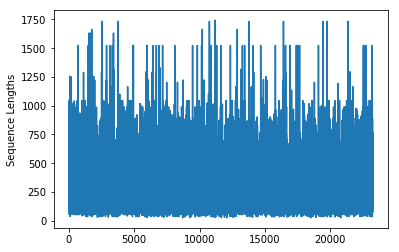

In [4]:
# Plot out the data
plt.plot(zinc_dataset['seq_length'])
plt.ylabel('Sequence Lengths')
plt.show()

## Remove Outliers using IQR

In [5]:
iqr = iqr(zinc_dataset['seq_length'])
mean = np.mean(zinc_dataset['seq_length'])
print('IQR : ', iqr)
print('Mean : ', mean)

IQR :  211.0
Mean :  306.6701243920286


In [6]:
# Holds quartile range
qr = list()
[qr.append( abs(len(row[5])-mean) ) for row in zinc_dataset.itertuples()]

# Add it to the dataframe
qr_col = pd.DataFrame({'quartiles' : qr})

**Outliers :** anything that abs(value - mean) > (1.5 * IQR)

In [7]:
num_before = len(zinc_dataset)

# Holds index to remove
rm_index = list()
index = 0
for row in qr_col.itertuples() : 
    if row[1] > (1.5 * iqr) : 
        rm_index.append(index)
    index += 1
    
# reverse sort the index
rm_index.sort(reverse=True)

# remove rows
for index in rm_index : 
    zinc_dataset = zinc_dataset.drop(zinc_dataset.index[index])
    
print("Before using IQR : ", num_before)
print("After using IQR : ", len(zinc_dataset))

Before using IQR :  23233
After using IQR :  21725


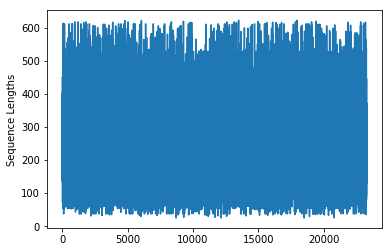

In [8]:
# Plot out the data
plt.plot(zinc_dataset['seq_length'])
plt.ylabel('Sequence Lengths')
plt.show()

In [9]:
maxlength = max(zinc_dataset['seq_length'])
print("Maximum sequence length : ", maxlength)

Maximum sequence length :  622


## Split Data into Training/Test/Validation Sets

In [10]:
# Split data into train:test (67:33)
train, target = train_test_split(zinc_dataset, test_size=0.33)
test, valid = train_test_split(target, test_size=.50)

### Combine Data that has Same Sequence but Different Fingerprints

In [11]:
uniqSeqTest = dict()
uniqSeqVal = dict()

for row in test.itertuples() : 
    if row[1] in uniqSeqTest : 
        # If sequence already in the dictionary, append fingerprints
        uniqSeqTest[row[1]] = uniqSeqTest[row[1]] + list(row[2])
    else :
        uniqSeqTest[row[1]] = list(row[2])

# Reduce down the repetitiveness of fingerprints
for k, v in uniqSeqTest.items() :
    uniqSeqTest[k] = set(v)
    
for row in valid.itertuples() : 
    if row[1] in uniqSeqVal : 
        # If sequence already in the dictionary, append fingerprints
        uniqSeqVal[row[1]] = uniqSeqVal[row[1]] + list(row[2])
    else :
        uniqSeqVal[row[1]] = list(row[2])

# Reduce down the repetitiveness of fingerprints
for k, v in uniqSeqVal.items() :
    uniqSeqVal[k] = set(v)

print('length of unique sequence in Test : ', len(uniqSeqTest))
print('length of unique sequence in Val : ', len(uniqSeqVal))

''' This part is to keep unique Zinc Data for ease of calculation during AASA '''
# Create dictionary with unique sets with fingerprints combined.
uniqZnData = dict()

for row in zinc_dataset.itertuples() :
    if row[5] in uniqZnData : 
        # If sequence already in the dictionary, append fingerprints
        uniqZnData[row[5]] = uniqZnData[row[5]] + list(row[3])
    else :
        uniqZnData[row[5]] = list(row[3])

# Reduce down the repetitiveness of fingerprints
for k, v in uniqZnData.items() :
    uniqZnData[k] = set(v)

length of unique sequence in Test :  3406
length of unique sequence in Val :  3410


### Convert Sequences to AASA

In [12]:
# Read in reference table
ref_table = pd.read_excel('sample_AAproperty.xlsx')
property_names = ref_table['property'].values
#ref_table = ref_table.drop('property', 1)
ref_table

,property,A,C,D,E,F,G,H,I,K,...,M,N,P,Q,R,S,T,V,W,Y
0,K_0,-25.50,-32.82,-33.12,-36.17,-34.54,-27.00,-31.84,-31.78,-32.40,...,-31.18,-30.90,-23.35,-32.60,-26.62,-29.88,-31.23,-39.62,-30.24,-35.01
1,H_t,0.87,1.52,0.66,0.67,2.87,0.10,0.87,3.15,1.64,...,1.67,0.09,2.77,0.00,0.85,0.07,0.07,1.87,3.77,2.67
2,H_p,13.05,14.30,11.10,11.41,13.89,12.20,12.42,15.34,11.01,...,13.62,11.72,11.06,11.78,12.40,11.68,12.12,14.73,13.96,13.57
3,P,0.00,1.48,49.70,49.90,0.35,0.00,51.60,0.10,49.50,...,1.43,3.38,1.58,3.53,52.00,1.67,1.66,0.13,2.10,1.61
4,pH_i,6.00,5.05,2.77,5.22,5.48,5.97,7.59,6.02,9.74,...,5.74,5.41,6.30,5.65,10.76,5.68,5.66,5.96,5.89,5.66
5,pK',2.34,1.65,2.01,2.19,1.89,2.34,1.82,1.36,2.18,...,2.28,2.02,1.99,2.17,1.81,2.21,2.10,2.32,2.38,2.20
6,M_w,89.00,121.00,133.00,147.00,165.00,75.00,155.00,131.00,146.00,...,149.00,132.00,115.00,146.00,174.00,105.00,119.00,117.00,204.00,181.00
7,P_1,11.50,13.46,11.68,13.57,19.80,3.40,13.67,21.40,15.71,...,16.25,12.82,17.43,14.45,14.28,9.47,15.77,21.57,21.61,18.03
8,R_f,9.90,2.80,2.80,3.20,18.80,5.60,8.20,17.10,3.50,...,14.70,5.40,14.80,9.00,4.60,6.90,9.50,14.30,17.00,15.00
9,m,14.34,35.77,12.00,17.26,29.40,0.00,31.81,19.06,21.29,...,21.64,13.28,10.93,17.56,26.66,6.53,11.01,13.92,42.53,31.55


In [13]:
def aasa(l, p, k, seq) :
    '''
    ' Parameter :
    '    l - spatial lag (int value)
    '    p - reference dataframe that holds all property values
    '    k - type of property
    '    seq - protein sequence
    '''
    summation = 0.0
    nonzeros = len(seq) - l
    
    for i in range( len(seq)-l ) :
        # Get indices
        fi = i
        li = i + l
        # Multiply them out and sum them
        p = ref_table.loc[k, seq[fi]] * ref_table.loc[k, seq[li]]
        summation += p
    return summation/nonzeros

def create_blocks(lag, ref_table, sequence) : 
    df_dict = {}
    counter = 0
    lag_names = list()

    # Automate lag names
    [lag_names.append("lag%i" %(i)) for i in range(1, lag+1)]
    
    # Actual Algorithm to fill the Dataframe with AASA
    for each_prop in range(len(ref_table)) :
        prop = list()
        for sp_lag in range(1, lag+1) :
            prop.append( aasa(sp_lag, ref_table, each_prop, sequence) )
        df_dict[property_names[each_prop]] = prop
        
    # Return DataFrame    
    return pd.DataFrame(df_dict, index=lag_names)

In [14]:
def aasa2(l, p, k, seq) :
    '''
    ' Parameter :
    '    l - spatial lag (int value)
    '    p - reference dataframe that holds all property values
    '    k - type of property
    '    seq - protein sequence
    '''
    summation = 0.0
    nonzeros = len(seq) - l
    
    for i in range( len(seq)-l ) :
        # Get indices
        fi = i
        li = i + l
        # Multiply them out and sum them
        p = ref_table.loc[k, seq[fi]] * ref_table.loc[k, seq[li]]
        summation += p
    
    #print(summation, " / ", nonzeros)
    return float(summation/nonzeros)

In [15]:
def create_blocks2(lag, ref_table, sequence) : 
    df_dict = {}
    counter = 0
    lag_names = list()
    lags = [1]

    ''' This part is to determine number of lags to observe '''
    fingerlist = uniqZnData[sequence]
    mx_finger = max(fingerlist)
    mn_finger = min(fingerlist)
    finger_range = mx_finger - mn_finger
    lag_apart = math.ceil(finger_range/(lag))        
    for _ in range(lag-1) : 
        lags.append(lags[_] + lag_apart)
    
    # Automate lag names
    [lag_names.append("lag%i" %(_)) for _ in lags ]
    
    # Actual Algorithm to fill the Dataframe with AASA
    for each_prop in range(len(ref_table)) :
        prop = list()

        for lg in lags :
            prop.append( aasa2(lg, ref_table, each_prop, sequence) )            
        df_dict[property_names[each_prop]] = prop
        
    # Return DataFrame    
    return pd.DataFrame(df_dict, index=lag_names)

In [16]:
# SAMPLE
seq = 'MGAPTLPPAWQPFLKDHRISTFKNWPFLEGCACTPERMAEAGFIHCPTENEPDLAQCFFCFKELEGWEPDDDPIEEHKKHSSGCAFLSVKKQFEELTLGEFLKLDRERAKNKIAKETNNKKKEFEETAKKVRRAIEQLAAMD'
sample_df = create_blocks2(5, ref_table, seq)
sample_df

,(neg)TdeltaS,E_sm,H_nc,H_p,H_t,K_0,M_w,P,P_1,R_f,delta_G,delta_H,m,pH_i,pK'
lag1,0.550977,1.459748,0.097128,155.208840,1.785567,969.827710,17721.184397,448.987319,227.516708,82.079220,0.055740,0.935561,341.026118,39.979405,4.388947
lag7,0.115062,1.448348,-0.072734,155.025681,1.824052,977.393810,17859.059259,374.939791,228.774013,81.972519,-0.004310,0.159010,350.073644,39.672454,4.357765
lag13,0.338561,1.454573,0.191316,154.873783,1.757246,981.782032,17827.984496,447.163775,225.953760,83.191860,0.018106,0.493298,345.685645,39.482234,4.377645
lag19,0.324431,1.457608,-0.044076,154.608873,1.880050,980.188846,17722.666667,328.512296,223.873572,76.969024,0.028636,0.595162,346.321266,39.348107,4.375348
lag25,0.440515,1.467879,0.065737,155.371949,1.785278,978.150805,17625.444444,408.392284,223.623671,77.499487,0.051089,0.723565,323.096547,38.868116,4.373507


In [17]:
rawX_train = deepcopy(train['sequence'])
rawX_test = deepcopy(test['sequence'])
rawX_valid = deepcopy(valid['sequence'])

rawy_train = deepcopy(train['fingerprint'])
rawy_test = deepcopy(test['fingerprint'])
rawy_valid = deepcopy(valid['fingerprint'])

In [18]:
# Convert training input values to matrix of AASA
X_train = [0] * len(rawX_train)
nlags = 12  # height of the table (number of rows)
index = 0

with progressbar.ProgressBar(max_value=len(rawX_train)) as bar:
    for i in range(len(rawX_train)):
        #print(list(rawX_train)[i])
        aasa_block = create_blocks2(nlags, ref_table, list(rawX_train)[i]).as_matrix()
        X_train[i] = aasa_block
        time.sleep(0.1)
        bar.update(i)

100% (14555 of 14555) |##################| Elapsed Time: 3:20:02 Time:  3:20:02


In [19]:
# Convert test input values to matrix of AASA
X_test = [0] * len(rawX_test)
nlags = 12
index = 0
        
with progressbar.ProgressBar(max_value=len(rawX_test)) as bar:
    for i in range(len(rawX_test)):
        aasa_block = create_blocks2(nlags, ref_table, list(rawX_test)[i]).as_matrix()
        X_test[i] = aasa_block
        time.sleep(0.1)
        bar.update(i)

100% (3585 of 3585) |####################| Elapsed Time: 0:40:31 Time:  0:40:31


In [20]:
# Convert valid input values to matrix of AASA
X_valid = [0] * len(rawX_valid)
nlags = 12
index = 0
        
with progressbar.ProgressBar(max_value=len(rawX_valid)) as bar:
    for i in range(len(rawX_valid)):
        aasa_block = create_blocks2(nlags, ref_table, list(rawX_valid)[i]).as_matrix()
        X_valid[i] = aasa_block
        time.sleep(0.1)
        bar.update(i)

100% (3585 of 3585) |####################| Elapsed Time: 0:40:21 Time:  0:40:21


In [21]:
y_train = list()
y_test = list()
y_valid = list()

# Use fingerprint indices to label the location of where metal binded.
for fingerprints in rawy_train :
    label = [0] * maxlength
    for fingerprint in fingerprints : 
        label[fingerprint] = 1
    y_train.append(label)
    
# same for test sample
for fingerprints in rawy_test :
    label = [0] * maxlength
    for fingerprint in fingerprints : 
        label[fingerprint] = 1
    y_test.append(label)

# same for valid sample
for fingerprints in rawy_valid :
    label = [0] * maxlength
    for fingerprint in fingerprints : 
        label[fingerprint] = 1
    y_valid.append(label)

### Normalize (Min-Max Normalization) X_train/X_test by columns
We do Min-Max since our data composed of signed values.

In [22]:
scaler = MinMaxScaler()

In [23]:
# Min-Max Normalization on Train
for i in range( len(X_train) ) :
    temp = pd.DataFrame( X_train[i] )
    scaler.fit(temp)
    X_train[i] = scaler.transform(temp)

# Min-Max Normalization on Test
for i in range( len(X_test) ) :
    temp = pd.DataFrame( X_test[i] )
    scaler.fit(temp)
    X_test[i] = scaler.transform(temp)
    
# Min-Max Normalization on Valid
for i in range( len(X_valid) ) :
    temp = pd.DataFrame( X_valid[i] )
    scaler.fit(temp)
    X_valid[i] = scaler.transform(temp)

In [24]:
len(X_valid)

3585

## Build CNN

In [25]:
# Importing all the necessary libraries to build CNN
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [26]:
batch_size = 64
epochs = 20
feature_num = 15
X_train_size = len(X_train)
X_test_size = len(X_test)
X_valid_size = len(X_valid)
width = X_train[0].shape[1]
height = X_train[0].shape[0]

In [32]:
def createModel() :
    classifier = Sequential()
    # This will create 32 Feature Maps. Input shape is referring to single sample.
    classifier.add(Conv2D(64, (3,3), input_shape=(width, height, 1), activation="relu", padding='same', kernel_initializer='he_normal'))
    classifier.add( BatchNormalization() )
    classifier.add(Conv2D(64, (3,3), input_shape=(width, height, 1), activation="relu", padding='same', kernel_initializer='he_normal'))
    classifier.add( BatchNormalization() )
    #classifier.add(MaxPooling2D(pool_size=(2,2), data_format="channels_first")) # (vertical, horizontal)
    classifier.add(MaxPooling2D(pool_size=(2,1))) # (vertical, horizontal)
    #classifier.add(Dropout(0.1))
    # Don't need 'input_shape' because it's already given from previous step.
    classifier.add( BatchNormalization() ) #<--------- JUST ADDED AND RAN : F1=0.6944
    classifier.add(Conv2D(128, (3,3), activation="relu", padding='same', kernel_initializer='he_normal'))
    classifier.add( BatchNormalization() )
    classifier.add(Conv2D(128, (3,3), activation="relu", padding='same', kernel_initializer='he_normal'))
    classifier.add( BatchNormalization() )
    #classifier.add(MaxPooling2D(pool_size=(2,2), data_format="channels_first")) # (vertical, horizontal)
    classifier.add(MaxPooling2D(pool_size=(2,1))) # (vertical, horizontal)
    #classifier.add(Dropout(0.1))

    classifier.add(Flatten())
    # Choose units to be not too big but not too small. Common practice is to pick power of 2.
    classifier.add(Dense(units=512, activation="relu"))
    classifier.add( BatchNormalization() )
    #classifier.add( Dropout(0.1) )
    classifier.add( Dense(maxlength, activation='softmax') )
    
    return classifier

In [33]:
model = createModel()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 12, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 12, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 12, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 12, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 12, 64)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 12, 64)         256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 12, 128)        73856     
__________

In [34]:
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
                              patience=3, 
                              verbose=1, 
                              factor=0.5, 
                              min_lr=0.001)

# categorical_crossentropy because we are classifying 2 outcomes.
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=['accuracy'])

In [40]:
# Fit the model (TRAINING)
X_train = np.array(X_train).reshape(X_train_size, width, height, 1)
X_test = np.array(X_test).reshape(X_test_size, width, height, 1)
X_valid = np.array(X_valid).reshape(X_valid_size, width, height, 1)

start = time.time()
# Trains the model for fixed number of epoches
model.fit(X_train, np.asarray(y_train), callbacks=[reduce_lr], validation_data=(X_valid, np.asarray(y_valid)), epochs=epochs, batch_size=batch_size)
end = time.time()
print("Model took %0.2f seconds" %(end - start))

Train on 14555 samples, validate on 3585 samples
Epoch 1/20
14555/14555 [==============================] - 130s 9ms/step - loss: 15.0597 - acc: 0.1382 - val_loss: 12.6899 - val_acc: 0.1816
Epoch 2/20
14555/14555 [==============================] - 135s 9ms/step - loss: 9.9345 - acc: 0.1958 - val_loss: 10.3523 - val_acc: 0.2031
Epoch 3/20
14555/14555 [==============================] - 137s 9ms/step - loss: 8.5057 - acc: 0.2087 - val_loss: 9.7110 - val_acc: 0.2042
Epoch 4/20
14555/14555 [==============================] - 136s 9ms/step - loss: 7.7615 - acc: 0.2179 - val_loss: 9.4358 - val_acc: 0.1880
Epoch 5/20
14555/14555 [==============================] - 127s 9ms/step - loss: 7.3457 - acc: 0.2203 - val_loss: 9.2125 - val_acc: 0.2131
Epoch 6/20
14555/14555 [==============================] - 132s 9ms/step - loss: 7.1081 - acc: 0.2264 - val_loss: 9.0341 - val_acc: 0.2195
Epoch 7/20
14555/14555 [==============================] - 153s 10ms/step - loss: 6.9143 - acc: 0.2215 - val_loss: 8.9494

In [43]:
loss, accuracy = model.evaluate(X_test, np.asarray(y_test), verbose=1)
print('loss : ', loss)
print('accuracy : ', accuracy)
prediction = model.predict(X_test)

3585/3585 [==============================] - 10s 3ms/step
loss :  8.384206457417381
accuracy :  0.16903765690376568


In [44]:
def getF1(sequence_index, label_set, pred, factor):
    
    prob_mean = np.mean(pred[sequence_index])
    prob_std = np.std(pred[sequence_index]) 
    prob_th = prob_mean+factor*prob_std
    
    cur_fp_ls = label_set[sequence_index]
    truePositive = 0
    falseNegative = 0
    for i in range(len(cur_fp_ls)):
        cur_index = cur_fp_ls[i]
        if pred[sequence_index][cur_index] >= prob_th:
            truePositive += 1
        else:
            falseNegative += 1
    
    Positive = 0
    Negative = 0
    for i in range(len(pred[sequence_index])):
        if pred[sequence_index][i] >= prob_th:
            Positive += 1
        else:
            Negative += 1
                
    return truePositive, falseNegative, Positive, Negative

In [46]:
tp_sum = 0
fn_sum = 0
p_sum = 0
n_sum = 0
factor = 4

for i in range(len(rawy_test)):
    tp,fn,p,n = getF1(i, rawy_test.tolist(), prediction,factor)
    tp_sum = tp_sum + tp
    fn_sum = fn_sum + fn
    p_sum = p_sum + p
    n_sum = n_sum + n

precision = tp_sum/p_sum
recall = tp_sum/(tp_sum+fn_sum) 
f1 = 2*precision*recall/(precision+recall)

print("precision = "+str(precision))
print("recall = "+str(recall))
print("f1 = "+str(f1))

precision = 0.588994708994709
recall = 0.8600788070771845
f1 = 0.6991803536098985


## Data Generator
* AASA

In [ ]:
train_args = {'sequences': train_seqs,
              'labels': train_label,
              'translator': seqs_dict_aasa}
val_args = {'sequences': val_seqs,
            'labels': val_label,
            'translator': seqs_dict_aasa}
common_args = {'batch_size': 100,
               'input_shape': (, ),
               'label_shape': (, ),
               'shuffle': True}

train_gen = modules.AASAGenerator(**train_args, **common_args)
val_gen = modules.AASAGenerator(**val_args, **common_args)